딥러닝응용 4주차 과제
==
Pretrain CNN Model + Fine-Tuning
* * *
- pytorch implementation
- error in fine tuning model (model not learning)
- submission #1



## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.utils import shuffle
import torch.optim as optim
from collections import Counter
from imblearn.over_sampling import SMOTE

## Data Preprocessing

Load Data

In [2]:
df = pd.read_csv('diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Check Data Types

In [3]:
df.dtypes

,0
Pregnancies,int64
Glucose,int64
BloodPressure,int64
SkinThickness,int64
Insulin,int64
BMI,float64
DiabetesPedigreeFunction,float64
Age,int64
Outcome,int64


Check for null values

In [4]:
df.isnull().sum()

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


Plot Data

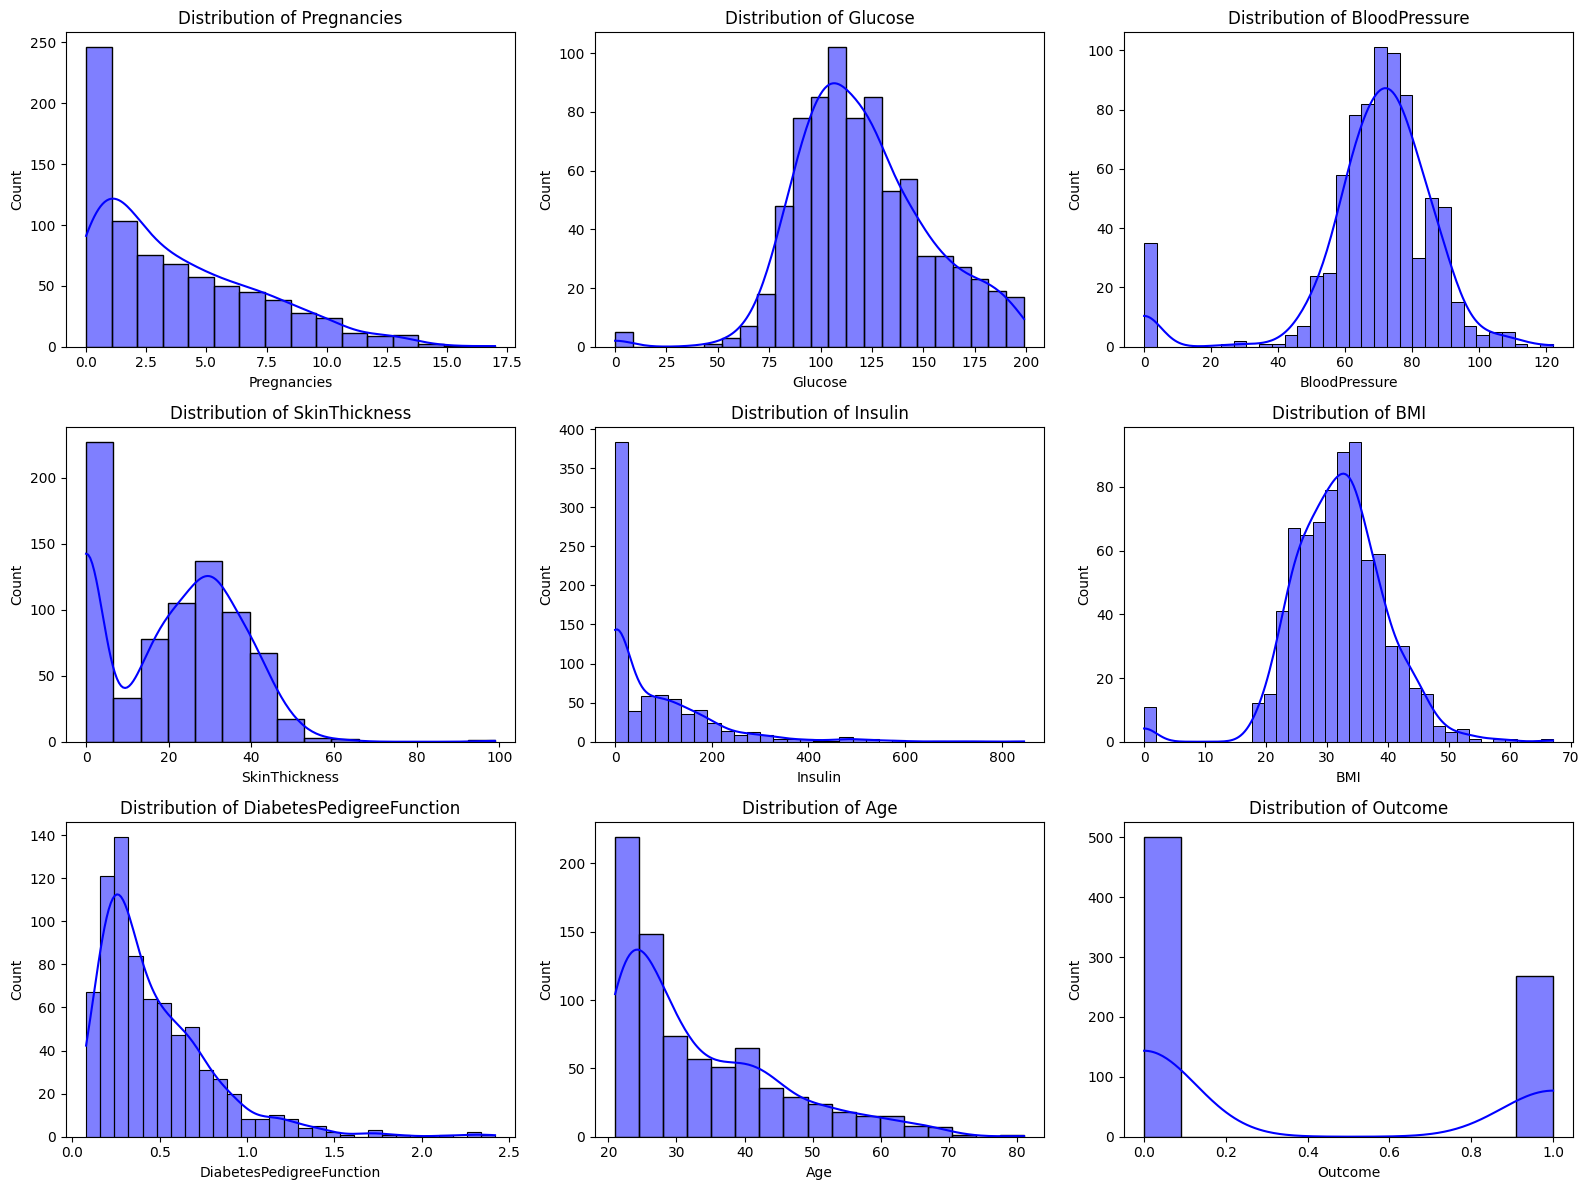

In [5]:
plt.figure(figsize=(16, 12))

columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
           'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

for i, column in enumerate(columns, 1):
    plt.subplot(3, 3, i)
    if df[column].dtype == 'int64' or df[column].dtype == 'float64':
        sns.histplot(df[column], kde=True, color='blue')
        plt.title(f'Distribution of {column}')
    else:
        sns.countplot(x=df[column], palette='Set2')
        plt.title(f'Count of {column}')

plt.tight_layout()
plt.show()

Create Target

In [6]:
x = df.drop(['Outcome'], axis=1)
y = df['Outcome']

Split Data

In [7]:
# Split Data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Split Val Data
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

Scale Data

In [8]:
# MinMaxScaler
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)
x_test_scaled = scaler.transform(x_test)

print(x_train_scaled.shape)
print(x_val_scaled.shape)
print(x_test_scaled.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(491, 8)
(123, 8)
(154, 8)
(491,)
(123,)
(154,)


Oversampling

In [11]:
# Apply SMOTE to handle class imbalance in the training set
smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train_scaled, y_train)

# Check the distribution after SMOTE
print("Class distribution before SMOTE:", Counter(y_train))
print("Class distribution after SMOTE:", Counter(y_train_resampled))

Class distribution before SMOTE: Counter({0: 320, 1: 171})
Class distribution after SMOTE: Counter({1: 320, 0: 320})


Create Sequences

In [12]:
def split_sequence(X, y, n_steps):
    X_seq, y_seq = list(), list()

    # Combine X and y into a DataFrame and shuffle
    df = pd.DataFrame(X)
    df['Outcome'] = y.reset_index(drop=True)  # Ensure indices match
    df = df.sample(frac=1, random_state=42)  # Shuffle the data

    # Create sequences
    for i in range(len(df) - n_steps):
        seq_x = df.iloc[i:i + n_steps, :-1].values  # Sequence of features
        seq_y = df.iloc[i + n_steps, -1]            # Corresponding label (Outcome)

        # Check if seq_y is NaN, if so, skip this sequence
        if pd.isna(seq_y):
            continue

        X_seq.append(seq_x)
        y_seq.append(seq_y)

    return np.array(X_seq), np.array(y_seq)

# def split_sequence(X, y, n_steps):
#     X_seq, y_seq = list(), list()

#     df = pd.DataFrame(X)
#     df['Output'] = y

#     grouped = df.groupby('Output')

#     for class_value, group in grouped:
#         if len(group) >= n_steps + 1:
#             sampled_group = group.sample(n=min(600, len(group)), random_state=42)
#             sampled_group = sampled_group.sort_index()
#             sampled_array = sampled_group.values

#             # Create sequences from the sampled data
#             for i in range(len(sampled_array) - n_steps):
#                 seq_x = sampled_array[i:i+n_steps, :-1].astype(np.float32)
#                 seq_y = sampled_array[i+n_steps, -1]
#                 X_seq.append(seq_x)
#                 y_seq.append(seq_y)

#     X_seq, y_seq = shuffle(X_seq, y_seq, random_state=42)
#     return np.array(X_seq), np.array(y_seq)

n_steps = 8

# Split sequences
x_train_seq, y_train_seq = split_sequence(x_train_resampled, y_train_resampled, n_steps)
x_val_seq, y_val_seq = split_sequence(x_val_scaled, y_val, n_steps)
x_test_seq, y_test_seq = split_sequence(x_test_scaled, y_test, n_steps)

# Reshape
x_train_seq = x_train_seq.reshape((x_train_seq.shape[0], 1, n_steps, -1))
x_val_seq = x_val_seq.reshape((x_val_seq.shape[0], 1, n_steps, -1))
x_test_seq = x_test_seq.reshape((x_test_seq.shape[0], 1, n_steps, -1))

# Check data
print(f"x_train_seq shape: {x_train_seq.shape}")
print(f"y_train_seq shape: {y_train_seq.shape}")

print(f"x_val_seq shape: {x_val_seq.shape}")
print(f"y_val_seq shape: {y_val_seq.shape}")

print(f"x_test_seq shape: {x_test_seq.shape}")
print(f"y_test_seq shape: {y_test_seq.shape}")

x_train_seq shape: (632, 1, 8, 8)
y_train_seq shape: (632,)
x_val_seq shape: (115, 1, 8, 8)
y_val_seq shape: (115,)
x_test_seq shape: (146, 1, 8, 8)
y_test_seq shape: (146,)


Check Sequences

In [13]:
# Sample output
print("\nSample of x_train_seq:")
print(x_train_seq[0])

print("\nSample of y_train_seq:")
print(y_train_seq[0])

# Check class label distribution
train_distribution = Counter(y_train_seq)
val_distribution = Counter(y_val_seq)
test_distribution = Counter(y_test_seq)

# Print distributions
print("\nTraining Class Distribution:")
print(train_distribution)

print("\nValidation Class Distribution:")
print(val_distribution)

print("\nTesting Class Distribution:")
print(test_distribution)


Sample of x_train_seq:
[[[0.34382011 0.68294201 0.71275374 0.         0.         0.56547817
   0.3757072  0.24801482]
  [0.71428571 0.58080808 0.         0.         0.         0.52608048
   0.02227171 0.13333333]
  [0.07142857 0.61616162 0.56140351 0.32323232 0.20967742 0.52309985
   0.27082405 0.15      ]
  [0.47700426 0.56823194 0.68955879 0.         0.         0.46962686
   0.05635309 0.26695149]
  [0.28571429 0.56060606 0.63157895 0.47474747 0.27822581 0.55290611
   0.58173719 0.58333333]
  [0.         0.60606061 0.64912281 0.18181818 0.08467742 0.45454545
   0.08953229 0.08333333]
  [0.14285714 0.42929293 0.57017544 0.         0.         0.59016393
   0.37683742 0.1       ]
  [0.35714286 0.39393939 0.42105263 0.         0.         0.50223547
   0.25389755 0.06666667]]]

Sample of y_train_seq:
0

Training Class Distribution:
Counter({0: 316, 1: 316})

Validation Class Distribution:
Counter({0: 72, 1: 43})

Testing Class Distribution:
Counter({0: 96, 1: 50})


Create Dataset and Dataloaders

In [16]:
train_dataset = TensorDataset(torch.Tensor(x_train_seq), torch.Tensor(y_train_seq))
val_dataset = TensorDataset(torch.Tensor(x_val_seq), torch.Tensor(y_val_seq))
test_dataset = TensorDataset(torch.Tensor(x_test_seq), torch.Tensor(y_test_seq))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Pretrain Model
==
pretrain a custom cnn model and save weights

In [17]:
class PretrainedCNN(nn.Module):
    def __init__(self):
        super(PretrainedCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(2048, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = PretrainedCNN()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(model)

PretrainedCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)


Metric Functions

In [18]:
# Function to calculate accuracy
def calculate_accuracy(outputs, labels):
    predicted = (outputs > 0.5).float()
    correct = (predicted == labels).float().sum()
    accuracy = correct / labels.size(0)
    return accuracy

# Function to validate model
def validate_model(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    total_accuracy = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            val_loss += loss.item()
            total_accuracy += calculate_accuracy(outputs, labels.unsqueeze(1)).item()
    return val_loss / len(val_loader), total_accuracy / len(val_loader)

# Function to test model
def test_model(model, test_loader):
    model.eval()
    all_labels = []
    all_preds = []
    total_accuracy = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            outputs = model(inputs)
            predicted = (outputs > 0.5).float()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

            accuracy = calculate_accuracy(outputs, labels.unsqueeze(1))
            total_accuracy += accuracy.item()

    print(f"Test Accuracy: {total_accuracy / len(test_loader):.4f}")
    return np.array(all_labels), np.array(all_preds)

Pretrain Model

In [19]:
def pretrain_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        total_accuracy = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            total_accuracy += calculate_accuracy(outputs, labels.unsqueeze(1)).item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = total_accuracy / len(train_loader)

        val_loss, val_accuracy = validate_model(model, val_loader, criterion)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies

# Pretrain
train_losses, val_losses, train_accuracies, val_accuracies = pretrain_model(model, train_loader, val_loader, criterion, optimizer, epochs=20)

Epoch 1/20, Train Loss: 0.6920, Train Accuracy: 0.5005, Val Loss: 0.6980, Val Accuracy: 0.6160
Epoch 2/20, Train Loss: 0.6947, Train Accuracy: 0.5026, Val Loss: 0.6906, Val Accuracy: 0.6160
Epoch 3/20, Train Loss: 0.6950, Train Accuracy: 0.5005, Val Loss: 0.6971, Val Accuracy: 0.6160
Epoch 4/20, Train Loss: 0.6920, Train Accuracy: 0.5005, Val Loss: 0.6985, Val Accuracy: 0.6160
Epoch 5/20, Train Loss: 0.6883, Train Accuracy: 0.4990, Val Loss: 0.6905, Val Accuracy: 0.6160
Epoch 6/20, Train Loss: 0.6856, Train Accuracy: 0.5005, Val Loss: 0.7056, Val Accuracy: 0.6160
Epoch 7/20, Train Loss: 0.6795, Train Accuracy: 0.5000, Val Loss: 0.6749, Val Accuracy: 0.6160
Epoch 8/20, Train Loss: 0.6781, Train Accuracy: 0.5115, Val Loss: 0.6916, Val Accuracy: 0.6160
Epoch 9/20, Train Loss: 0.6605, Train Accuracy: 0.5031, Val Loss: 0.6960, Val Accuracy: 0.6135
Epoch 10/20, Train Loss: 0.6514, Train Accuracy: 0.5516, Val Loss: 0.7073, Val Accuracy: 0.5954
Epoch 11/20, Train Loss: 0.6495, Train Accuracy: 

Save Pretrained Model

In [20]:
torch.save(model.state_dict(), 'pretrained_cnn.pth')

Plot Train-Val Metrics

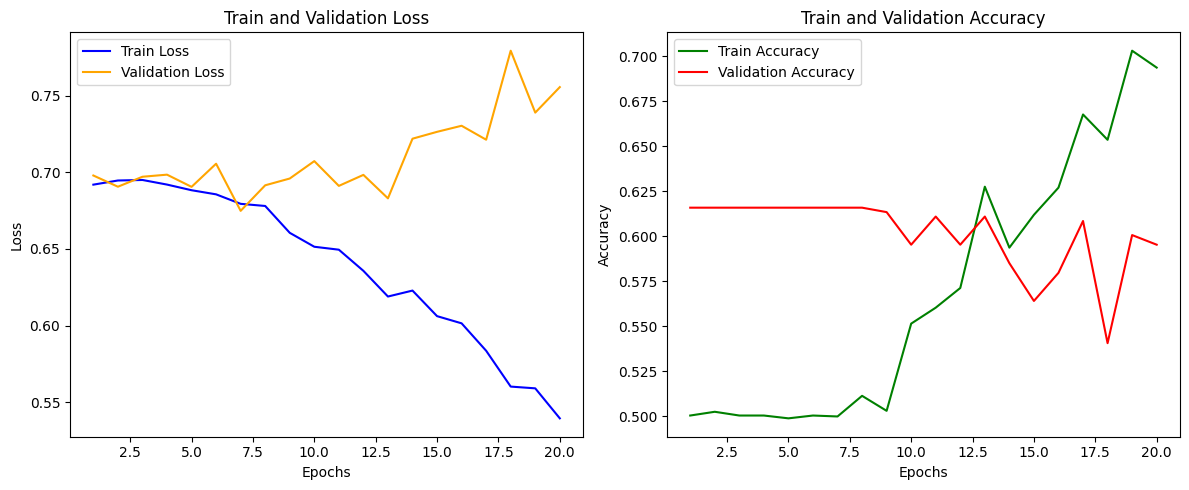

In [21]:
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, epochs):
    epochs_range = range(1, epochs + 1)

    # Plot Loss
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss', color='blue')
    plt.plot(epochs_range, val_losses, label='Validation Loss', color='orange')
    plt.title('Train and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label='Train Accuracy', color='green')
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy', color='red')
    plt.title('Train and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, epochs=20)

Test Pretrained Model

In [22]:
# Test the pretrained model
y_true, y_pred = test_model(model, test_loader)

Test Accuracy: 0.5722


Plot Confusion Matrix

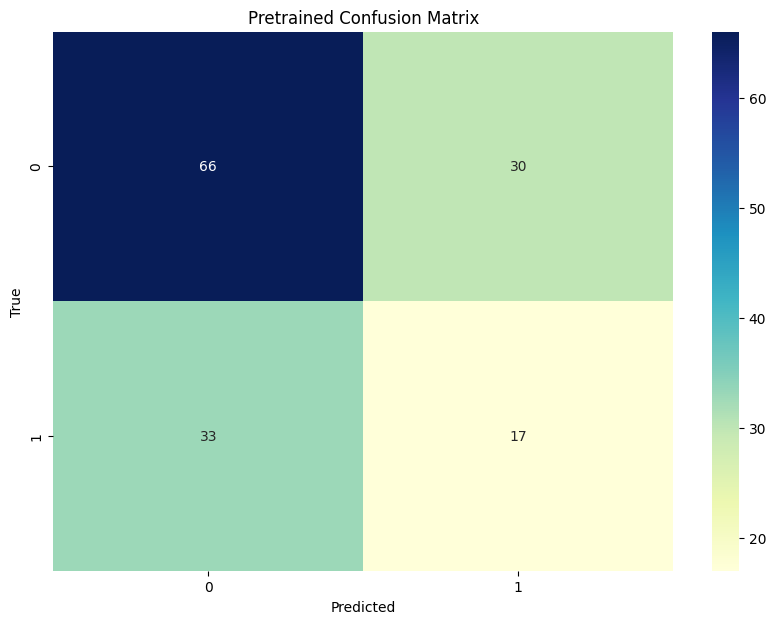

In [23]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Pretrained Confusion Matrix')
plt.show()

Fine-Tuning
==
load the saved pretrained model and add 2 dense layers

In [30]:
# class NewCNN(nn.Module):
#     def __init__(self, pretrained_model):
#         super(NewCNN, self).__init__()
#         # Load the pretrained layers
#         self.pretrained = pretrained_model
#         # Freeze pretrained layers to avoid updating their weights
#         for param in self.pretrained.parameters():
#             param.requires_grad = False

#         # Add new fully connected layers for fine-tuning
#         self.fc2 = nn.Linear(1, 64)  # New fully connected layer (input = pretrained output = 1)
#         self.dropout = nn.Dropout(0.5)
#         self.fc3 = nn.Linear(64, 1)  # Output layer

#     def forward(self, x):
#         # Use pretrained layers
#         x = self.pretrained(x)
#         x = torch.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

class NewCNN(nn.Module):
    def __init__(self, pretrained_model):
        super(NewCNN, self).__init__()
        # Load the pretrained layers
        self.pretrained = pretrained_model

        # Remove the last layer of the pretrained model
        self.pretrained.fc2 = nn.Identity()  # Assuming fc2 is the last layer in pretrained model

        # Freeze pretrained layers to avoid updating their weights
        for param in self.pretrained.parameters():
            param.requires_grad = False

        # Add new fully connected layers for fine-tuning
        self.fc3 = nn.Linear(128, 64)  # Adjust input size based on the output of pretrained model
        #self.dropout = nn.Dropout(0.5)
        self.fc4 = nn.Linear(64, 1)  # Output layer

    def forward(self, x):
        # Use pretrained layers
        x = self.pretrained(x)
        x = torch.relu(self.fc3(x))
        #x = self.dropout(x)
        x = self.fc4(x)
        return x

In [31]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.00001)
criterion = nn.BCEWithLogitsLoss()

Load pretrained model and Initialize new model

In [32]:
# Load the pretrained model
pretrained_model = PretrainedCNN()
pretrained_model.load_state_dict(torch.load('pretrained_cnn.pth', weights_only=True))
pretrained_model.to(device)

# New model
model = NewCNN(pretrained_model)
model.to(device)

print(model)

NewCNN(
  (pretrained): PretrainedCNN(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fc1): Linear(in_features=2048, out_features=128, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (fc2): Identity()
  )
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=1, bias=True)
)


In [33]:
for name, param in model.named_parameters():
    print(f"{name}: {param.requires_grad}")

pretrained.conv1.weight: False
pretrained.conv1.bias: False
pretrained.conv2.weight: False
pretrained.conv2.bias: False
pretrained.fc1.weight: False
pretrained.fc1.bias: False
fc3.weight: True
fc3.bias: True
fc4.weight: True
fc4.bias: True


Fine-tune model

In [34]:
def fine_tune_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        total_accuracy = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            optimizer.zero_grad()
            outputs = model(inputs)
            print(outputs)
            predicted = (outputs > 0.5).float()
            loss = criterion(outputs, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            total_accuracy += calculate_accuracy(outputs, labels.unsqueeze(1)).item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = total_accuracy / len(train_loader)

        # Validation
        val_loss, val_accuracy = validate_model(model, val_loader, criterion)

        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f"Fine-tuning Epoch {epoch+1}/{epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies

In [40]:
def fine_tune_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        running_loss = 0.0
        total_accuracy = 0.0
        model.train()  # Ensure model is in training mode

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()

            optimizer.zero_grad()
            outputs = model(inputs)

            # Debugging outputs and labels
            print(f"Outputs: {outputs[:5]}")  # Printing first 5 outputs for inspection
            print(f"Labels: {labels[:5]}")    # Printing first 5 labels for inspection

            predicted = (outputs > 0.5).float()
            print(f"Predicted: {predicted[:5]}")
            loss = criterion(outputs, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            total_accuracy += calculate_accuracy(predicted, labels.unsqueeze(1)).item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = total_accuracy / len(train_loader)

        # Validation
        val_loss, val_accuracy = validate_model(model, val_loader, criterion)

        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies

def calculate_accuracy(predicted, labels):
    correct = (predicted == labels).sum().float()
    accuracy = correct / labels.shape[0]
    return accuracy

In [41]:
# Fine-tune
train_losses_ft, val_losses_ft, train_accuracies_ft, val_accuracies_ft = fine_tune_model(model, train_loader, val_loader, criterion, optimizer, epochs=50)

Streaming output truncated to the last 5000 lines.
Predicted: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]])
Outputs: tensor([[-0.0133],
        [-0.0855],
        [ 0.0628],
        [ 0.0005],
        [-0.0113]], grad_fn=<SliceBackward0>)
Labels: tensor([1., 0., 0., 1., 0.])
Predicted: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]])
Outputs: tensor([[ 0.0799],
        [-0.1380],
        [-0.0773],
        [-0.0253],
        [ 0.0298]], grad_fn=<SliceBackward0>)
Labels: tensor([0., 0., 0., 0., 1.])
Predicted: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]])
Outputs: tensor([[ 0.0335],
        [-0.0457],
        [ 0.0155],
        [-0.0313],
        [-0.0022]], grad_fn=<SliceBackward0>)
Labels: tensor([1., 1., 1., 1., 1.])
Predicted: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]])
Outputs: tensor([[ 0.0373],
        [-0.0084],
        [ 0.0220],
        [-0.0413],
        [-0.0009]], grad_fn=<Sli

Plot train-val graph

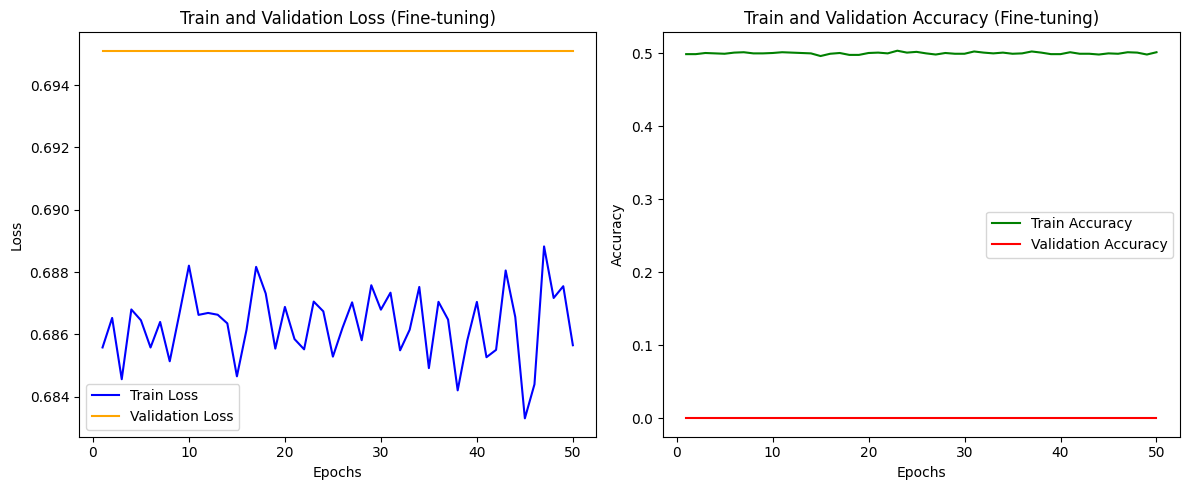

In [37]:
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, epochs, title_suffix=""):
    epochs_range = range(1, epochs + 1)

    # Plot Loss
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss', color='blue')
    plt.plot(epochs_range, val_losses, label='Validation Loss', color='orange')
    plt.title(f'Train and Validation Loss {title_suffix}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label='Train Accuracy', color='green')
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy', color='red')
    plt.title(f'Train and Validation Accuracy {title_suffix}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot
plot_metrics(train_losses_ft, val_losses_ft, train_accuracies_ft, val_accuracies_ft, epochs=50, title_suffix="(Fine-tuning)")

In [38]:
# Test the fine-tuned model
y_true, y_pred = test_model(model, test_loader)

Test Accuracy: 0.0000


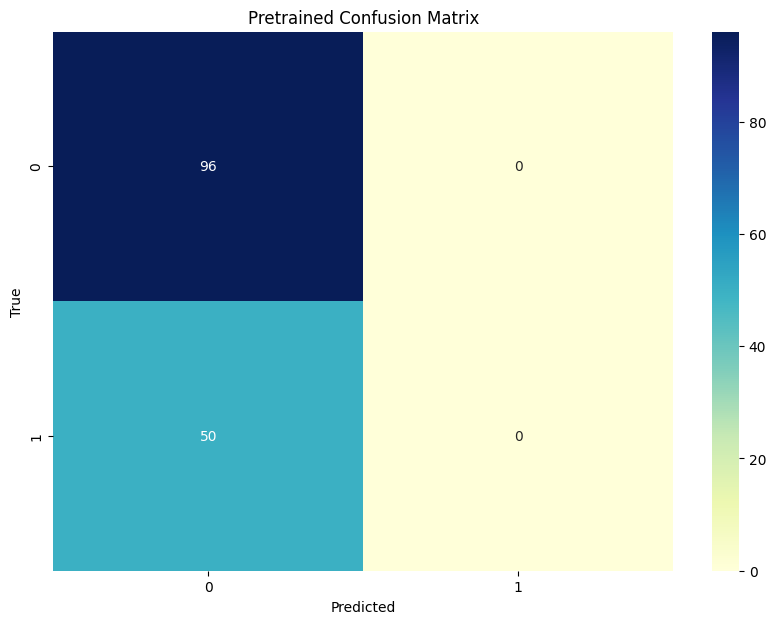

In [39]:
# Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Pretrained Confusion Matrix')
plt.show()